## **Import libraries**

In [1]:
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import re
%matplotlib inline
import pickle

In [2]:
import nltk
from nltk import word_tokenize
from nltk import ngrams
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mayar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## **Read and Explore data**

In [3]:
df = pd.read_csv('Job titles and industries.csv')
df = df[pd.notnull(df['industry'])]

In [4]:
df.head(10)

,job title,industry
0,technical support and helpdesk supervisor - co...,IT
1,senior technical support engineer,IT
2,head of it services,IT
3,js front end engineer,IT
4,network and telephony controller,IT
5,privileged access management expert,IT
6,devops engineers x 3 - global brand,IT
7,devops engineers x 3 - global brand,IT
8,data modeller,IT
9,"php web developer £45,000 based in london",IT


In [5]:
df.shape

(8586, 2)

In [6]:
df.describe()

,job title,industry
count,8586,8586
unique,3890,4
top,marketing executive,IT
freq,91,4746


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8586 entries, 0 to 8585
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   job title  8586 non-null   object
 1   industry   8586 non-null   object
dtypes: object(2)
memory usage: 201.2+ KB


In [8]:
df.columns

Index(['job title', 'industry'], dtype='object')

In [9]:
print(df['job title'].apply(lambda x: len(x.split(' '))).sum())

35228


## **Functions**

In [10]:
def print_element(index):
    """
    Have a look on few job titles and industry pairs
    
    """
    example = df[df.index == index][['job title', 'industry']].values[0]
    if len(example) > 0:
        print(example[0])
        print('industry:', example[1])

In [11]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified strings in job titles
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub('', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    text = re.sub(r'\d', '', text)
    return text

In [12]:
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    """
    Word cloud for job titles 
    
    in which the size of each word indicates 
    
    its frequency or importance. 
    
    """
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [13]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

    """
    
    Frequently occurring terms[job titles] 
    
    for each class[Industry]
    
    """

def top_feats_in_doc(Xtr, features, row_id, top_n=20):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=10):
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=20):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs, num_class=4):
    
    fig = plt.figure(figsize=(12, 100), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        #z = int(str(int(i/3)+1) + str((i%3)+1))
        ax = fig.add_subplot(num_class, 1, i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=16)
        ax.set_ylabel("Word", labelpad=16, fontsize=16)
        ax.set_title("Class = " + str(df.label), fontsize=25)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature)
        
        for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(20) 
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

## **Data Visualization**

#### Word cloud to show the importance of words according to its size:

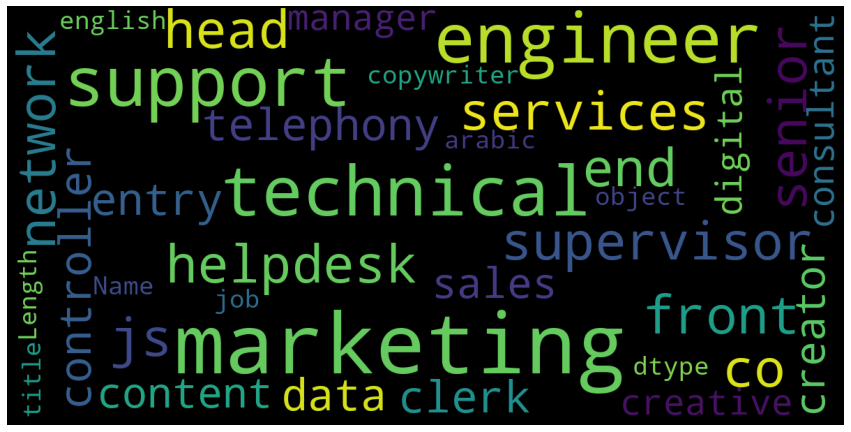

In [14]:
show_wordcloud(df['job title'])

In [15]:
vectorizer=TfidfVectorizer(ngram_range=(1,2))

In [16]:
job_title_vectorized = vectorizer.fit_transform(df['job title'])

#### **Frequently occured job title in each class:**

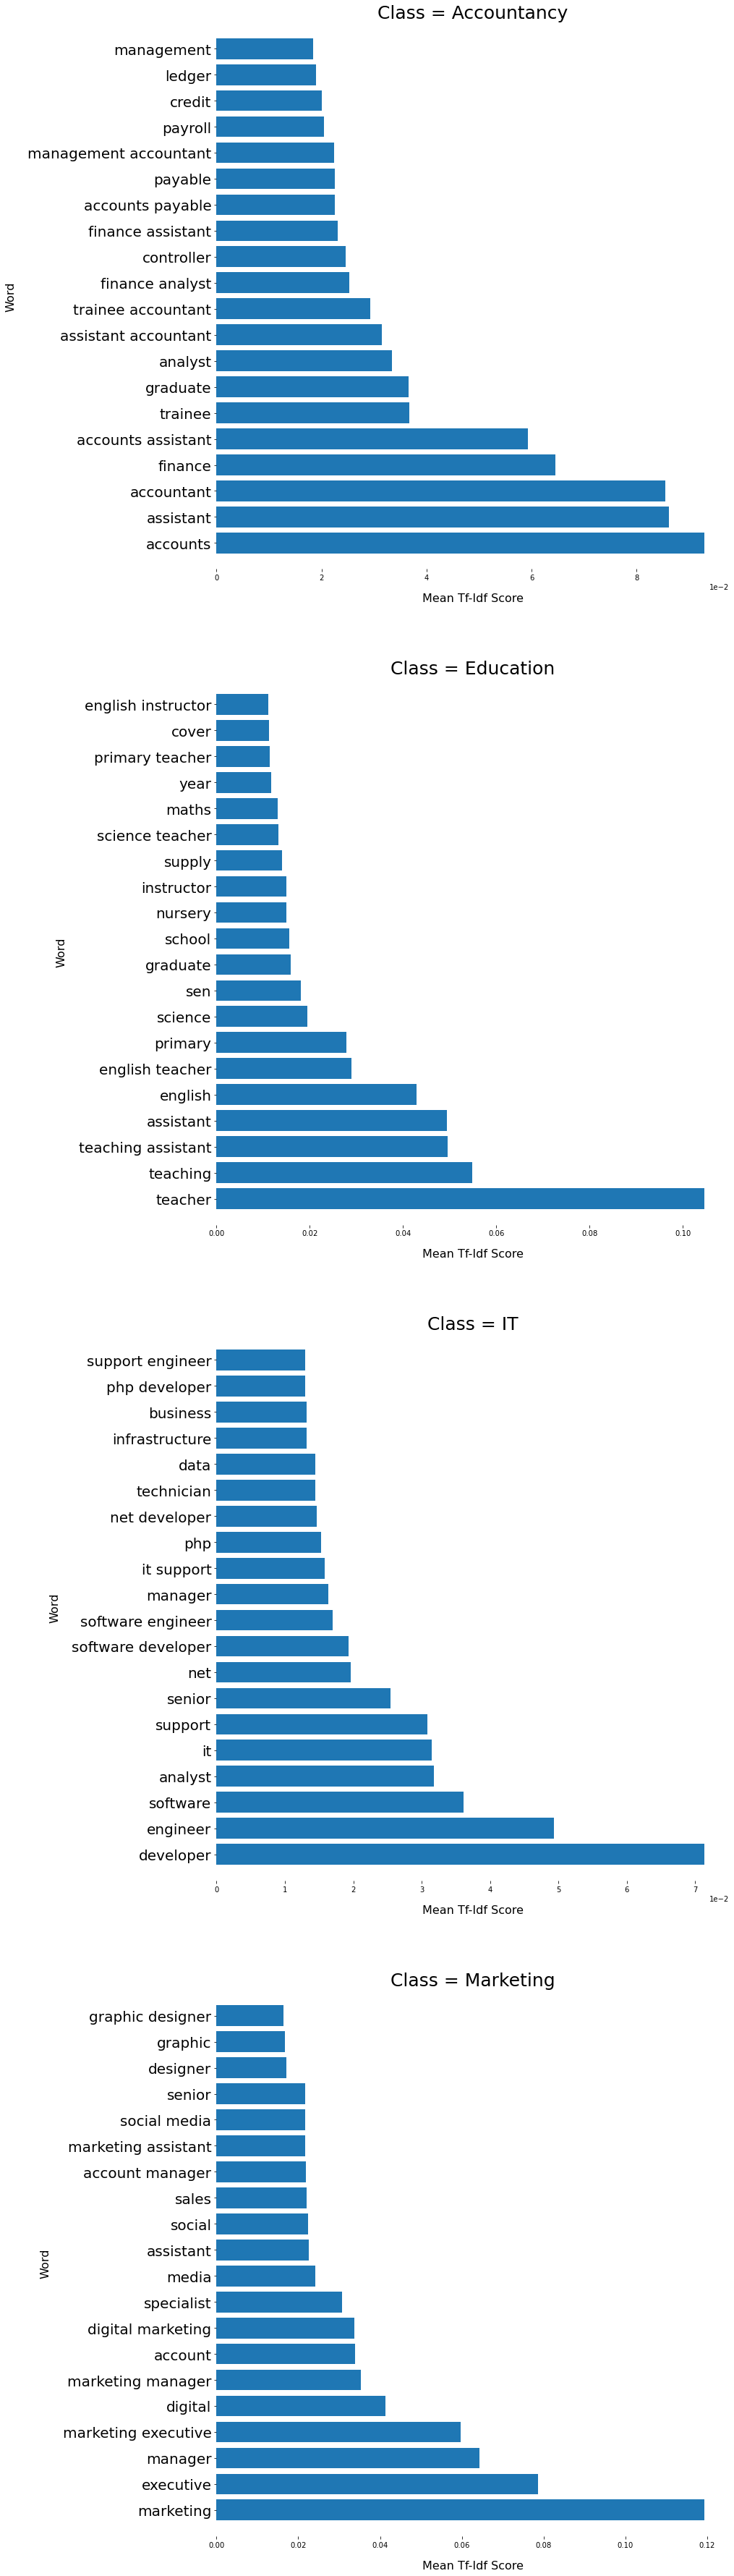

In [17]:
class_y = df['industry']
class_features = vectorizer.get_feature_names()
class_top_dfs = top_feats_by_class(job_title_vectorized, class_y, class_features)
plot_tfidf_classfeats_h(class_top_dfs, 7)

## **Data Preprocessing and Cleaning**

In [18]:
print(df['job title'].apply(lambda x: len(x.split(' '))).sum())

35228


In [19]:
print_element(250)

salesforce consultant / business analyst
industry: IT


In [20]:
df['job title'] = df['job title'].apply(clean_text)
print_element(250)

salesforce consultant business analyst
industry: IT


In [21]:
clean_text('salesforce consultant / business analyst')

'salesforce consultant business analyst'

In [22]:
print(df['job title'].apply(lambda x: len(x.split(' '))).sum())

30521


In [23]:
tf_vectorizer=TfidfVectorizer(ngram_range=(1,2))

**vectorizing data:**

In [24]:
data = tf_vectorizer.fit_transform(df['job title'])

In [25]:
data_ = pd.DataFrame(data.toarray(), columns=np.array(tf_vectorizer.get_feature_names()))

In [26]:
data_

,aat,aat accounts,aat cima,aat level,aberdeen,aberdeen school,aberfoyle,aberfoyle primary,abingdon,abroad,...,york,york pd,yorkshire,young,young learners,young scholar,youth,youth mentor,youtube,youtube specialist
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## **Split Data**

In [27]:
X = data_
y = df.industry
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [28]:
type(X_train)

pandas.core.frame.DataFrame

## **Model Train**

#### **Multinomial Naive Baise**

In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
my_industries = ['IT', 'Marketing', 'Education', 'Accountancy']

# nb = Pipeline([('vect', CountVectorizer()),
#                ('tfidf', TfidfTransformer()),
#                ('clf', MultinomialNB()),
#               ])
nb = MultinomialNB()
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_industries))

accuracy 0.9132712456344587
              precision    recall  f1-score   support

          IT       0.91      0.46      0.62        69
   Marketing       0.96      0.83      0.89       309
   Education       0.93      0.98      0.95       942
 Accountancy       0.85      0.91      0.88       398

    accuracy                           0.91      1718
   macro avg       0.91      0.79      0.83      1718
weighted avg       0.92      0.91      0.91      1718



#### **RandomForestClassifier**

In [34]:
from sklearn.ensemble import RandomForestClassifier

tfidf = TfidfVectorizer(stop_words='english')


rf = RandomForestClassifier()
rf.fit(X_train, y_train)
print(rf.score(X_test, y_test))
predictions = rf.predict(X_test)
# print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.9336437718277066
              precision    recall  f1-score   support

 Accountancy       0.98      0.74      0.84        69
   Education       0.92      0.89      0.90       309
          IT       0.96      0.97      0.97       942
   Marketing       0.88      0.91      0.89       398

    accuracy                           0.93      1718
   macro avg       0.93      0.88      0.90      1718
weighted avg       0.93      0.93      0.93      1718



#### **Support Vector Machine** 

In [35]:
from sklearn import svm
from sklearn.metrics import classification_report

clf = svm.LinearSVC()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(clf.score(X_test,y_test))
print(classification_report(y_test, y_pred))

0.9423748544819558
              precision    recall  f1-score   support

 Accountancy       0.98      0.81      0.89        69
   Education       0.96      0.89      0.92       309
          IT       0.96      0.98      0.97       942
   Marketing       0.89      0.92      0.91       398

    accuracy                           0.94      1718
   macro avg       0.95      0.90      0.92      1718
weighted avg       0.94      0.94      0.94      1718



**Observation: SVM is the Best Model**

In [36]:
X_train.shape

(6868, 7957)

In [37]:
# Saving model to disk
pickle.dump(clf, open('model.pkl','wb'))

In [38]:
# Loading model to compare the results
model = pickle.load(open('model.pkl','rb'))

In [39]:
result = model.score(X_test, y_test)
print(result)

0.9423748544819558


#### **Testing the model on some job titles:**

In [40]:
def classify(jobTitle_text):
    global model
    global tf_vectorizer
    global data
    jobTitle=tf_vectorizer.transform([jobTitle_text])
    labels=df['industry']
    categories=df['industry']
    look_up=dict(zip(labels,categories))
    return look_up[clf.predict(jobTitle)[0]]

In [41]:
artice_text="teacher"

In [42]:
classify(artice_text)

'Education'